# Analyses
- all neuronal pairwise correlations during sleep deprivation go here

# Distribution of pairwise correlations during SD from first to last hour of SD
- also compare with nsd 1st hour of sleep vs 5th hour sleep

In [ ]:
import numpy as np
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess
sessions_nsd = subjects.nsd.allsess[:-1]

In [ ]:
%matplotlib inline
figure = Fig()
fig,gs = figure.draw(grid=(2,2),style='Pres')
gs_ = figure.subplot2grid(gs[:,1],grid=(5,2),hspace=0.5)
all_corr_sd = []

cdf = lambda x: np.cumsum(x)/np.sum(x)

bins = np.arange(-0.1,0.4,0.01)
for sub, sess in enumerate(sessions_sd):
    post = sess.paradigm['post']
    sd = [post[0],post[0]+5*3600]

    neurons = sess.neurons.get_neuron_type('pyr')
    cal_pair_corr=lambda t:neurons.get_binned_spiketrains(t_start=t,t_stop=t+3600).get_pairwise_corr()
    corr_pair = np.asarray( [cal_pair_corr(_) for _ in [sd[0],sd[0]+4*3600]])
    f_h = np.histogram(corr_pair[0],bins=bins)[0]
    l_h = np.histogram(corr_pair[1],bins=bins)[0]

    ax = plt.subplot(gs_[sub])
    ax.plot(bins[:-1],cdf(f_h))
    ax.plot(bins[:-1],cdf(l_h))
    ax.set_title(f'sub {sub}')
    all_corr_sd.append(corr_pair)

all_corr_nsd=[]
for sub, sess in enumerate(sessions_nsd,sub+2):
    post = sess.paradigm['post']

    neurons = sess.neurons.get_neuron_type('pyr')
    cal_pair_corr=lambda t:neurons.get_binned_spiketrains(t_start=t,t_stop=t+3600).get_pairwise_corr()
    corr_pair = np.asarray( [cal_pair_corr(_) for _ in [post[0],post[0]+4*3600]])
    f_h = np.histogram(corr_pair[0],bins=bins)[0]
    l_h = np.histogram(corr_pair[1],bins=bins)[0]

    ax = plt.subplot(gs_[sub])
    ax.plot(bins[:-1],cdf(f_h))
    ax.plot(bins[:-1],cdf(l_h))
    ax.set_title(f'sub {sub}')

    all_corr_nsd.append(corr_pair)




ax = plt.subplot(gs[0])
all_corr_sd = np.hstack(all_corr_sd)
first_h_sd = np.histogram(all_corr_sd[0],bins=bins)[0]
last_h_sd = np.histogram(all_corr_sd[1],bins=bins)[0]

all_corr_nsd = np.hstack(all_corr_nsd)
first_h_nsd = np.histogram(all_corr_nsd[0],bins=bins)[0]
last_h_nsd = np.histogram(all_corr_nsd[1],bins=bins)[0]

ax.plot(bins[:-1],cdf(first_h_sd),'r',label='sd_ZT1')
ax.plot(bins[:-1],cdf(last_h_sd),'g',label='sd_ZT5')
ax.plot(bins[:-1],cdf(first_h_nsd),'k',label='nsd_ZT1')
ax.plot(bins[:-1],cdf(last_h_nsd),'gray',label='nsd_ZT5')

ax.legend()
ax.set_xlabel('Pairwise correlation')
ax.set_ylabel('Probability')

# Compare pariwise correlation using scatter plot from first to last hour of sleep deprivation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from neuropy.plotting import Fig
from scipy.ndimage import gaussian_filter1d
import subjects

sd_sessions = subjects.sd.allsess[2:-1]
nsd_sessions = subjects.nsd.ratNday2 + subjects.nsd.ratSday2 + subjects.nsd.ratUday2
print(sd_sessions)

[ProcessData(RatN_Day1_2019-10-09_03-52-32.xml), ProcessData(RatS_Day3SD_2020-11-29_07-53-30.xml), ProcessData(RatR_Day2SD_2021-05-23_09-07-18.xml), ProcessData(RatU_Day4SD_2021-07-29_08-23-06.xml)]


In [14]:
pcorr_sd = []
pcorr_nsd = []
for grp_ind, sessions in enumerate([sd_sessions, nsd_sessions]):
    for sub, sess in enumerate(sessions):
        maze = sess.paradigm["maze"]
        rec_duration = sess.eegfile.duration
        neurons = sess.neurons.get_neuron_type("mua")

        bin_size = 60
        pcorr_sub = []
        for start in [maze[0], maze[0] + 4 * 3600]:
            pcorr = (
                neurons.time_slice(start, start + 3600)
                .get_binned_spiketrains(bin_size=bin_size)
                .get_pairwise_corr()
            )
            pcorr_sub.append(pcorr)
        pcorr_sub = np.asarray(pcorr_sub).T
    if grp_ind==0:
        pcorr_sd.append(pcorr_sub)

    if grp_ind==1:
        pcorr_nsd.append(pcorr_sub)

pcorr_sd = np.vstack(pcorr_sd)
pcorr_nsd = np.vstack(pcorr_nsd)

/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


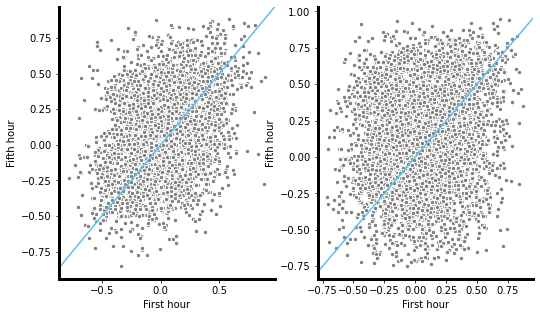

In [46]:
%matplotlib inline
figure = Fig()
fig,gs = figure.draw(grid=(2,2),style='Pres')

for i,pcorr in enumerate([pcorr_sd,pcorr_nsd]):
    ax = plt.subplot(gs[i])
    ax.scatter(pcorr[:,0],pcorr[:,1],s=20,c='gray',marker='o',edgecolors='w')
    # ax.hexbin(pcorr[:,0],pcorr[:,1],cmap='inferno',gridsize=50)
    ax.axline((0,0),slope=1)
    ax.set_xlabel('First hour')
    ax.set_ylabel('Fifth hour')

# Pairwise correlation across time each session individually

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
import subjects
import pandas as pd
from neuropy.analyses import neurons_correlation

# sessions = subjects.sd.ratNday1+ subjects.sd.ratSday3+ subjects.sd.ratRday2 + subjects.sd.ratUday4

sessions = subjects.nsd.ratNday2 + subjects.nsd.ratSday2 + subjects.nsd.ratUday2


In [23]:
# sessions = subjects.Sd().allsess + subjects.Nsd().allsess
pair_corr_all = []
for sub, sess in enumerate(sessions):
    neurons = sess.neurons.get_neuron_type('pyr')
    pair_corr = neurons_correlation.corr_across_time_window(neurons)
    np.fill_diagonal(pair_corr,val=0)
    pair_corr_all.append(pair_corr)

/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [21]:
%matplotlib widget
from scipy.ndimage import gaussian_filter
figure = plotting.Fig()
fig, gs = figure.draw(num=1, grid=(3, 2),hspace=0.25)

rat_names = ['Rat N','Rat S','Rat U']
for i,pair_corr in enumerate(pair_corr_all):
    ax = plt.subplot(gs[i])
    sns.heatmap(pair_corr,ax=ax,cmap='jet',rasterized=True)
    ax.set_title(f"{rat_names[i]}")

fig.suptitle('Window = 300 s, Bin size = 0.25 s')
figure.savefig(subjects.figpath_sd/'NSD_correlation_across_time')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Pairwise correlation across pooled across sessions

In [ ]:
sessions = subjects.Sd().allsess + subjects.Nsd().allsess
# sessions = subjects.Sd().ratJday1
corr_sd, corr_nsd = [], []
for sub, sess in enumerate(sessions):

    pre = sess.epochs.pre
    maze1 = sess.epochs.maze
    if maze1 is None:
        maze1 = sess.epochs.maze1
    post = sess.epochs.post
    tag = sess.recinfo.animal.tag

    # --- break region into periods --------
    # bins = sess.utils.getinterval([post[0], post[0] + 5 * 3600], 2)
    # sess.spikes.stability.firingRate(periods=bins)
    spks = sess.spikes.pyr
    epochs = np.arange(post[0], post[0] + 8 * 3600, 300)
    corr = []
    for i in range(len(epochs) - 1):
        corr.append(
            sess.spikes.corr.pairwise(spikes=spks, period=[epochs[i], epochs[i + 1]])
        )
    corr = np.asarray(corr)

    if tag == "sd":
        corr_sd.append(corr)
    else:
        corr_nsd.append(corr)


def process_(corr_mat):
    corr_mat = np.hstack(corr_mat)
    corr_mask = np.ma.array(corr_mat, mask=np.isnan(corr_mat))
    corr_ = np.ma.corrcoef(corr_mask)
    np.fill_diagonal(corr_, 0)
    # corr_ = gaussian_filter(corr_, sigma=1)
    return corr_


corr_sd = process_(corr_sd)
corr_nsd = process_(corr_nsd)

time = np.linspace(0, 8, corr_sd.shape[0] + 1)

figure = Fig()
fig, gs = figure.draw(num=1, grid=(4, 3), wspace=0.3)
axsd = plt.subplot(gs[2])
im = axsd.pcolormesh(time[:-1], time[:-1], corr_sd, cmap="Spectral_r", rasterized=True)
axsd.set_xlabel("Time (h)")
axsd.set_ylabel("Time (h)")
cbar = fig.colorbar(im, ax=axsd)
cbar.outline.set_linewidth(1)


axnsd = plt.subplot(gs[5])
im = axnsd.pcolormesh(
    time[:-1], time[:-1], corr_nsd, cmap="Spectral_r", rasterized=True
)
axnsd.set_xlabel("Time (h)")
cbar = fig.colorbar(im, ax=axnsd)
cbar.outline.set_linewidth(1)
# cbar.set_label("correlation")

figure.savefig("correlation_time_window", __file__)

# Mean pairwise correlation

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
import subjects
import pandas as pd
from neuropy.analyses import neurons_correlation

# sessions = (
#     subjects.sd.ratNday1
#     + subjects.sd.ratSday3
#     + subjects.sd.ratRday2
#     + subjects.sd.ratUday4
# )

sessions = subjects.nsd.ratNday2 + subjects.nsd.ratSday2 + subjects.nsd.ratUday2


In [7]:
from neuropy.utils import mathutil

pcorr_df = pd.DataFrame()
for sub, sess in enumerate(sessions):

    neurons = sess.neurons.get_neuron_type("pyr")
    post = sess.paradigm["post"]
    sd = [post[0], post[0] + 5 * 3600]

    t_starts = np.arange(0, 5 * 3600 / 600) * 600 + sd[0]

    pcorr_sub = np.zeros(len(t_starts))
    for i, start in enumerate(t_starts):

        pair_corr = (
            neurons.time_slice(start, start + 600)
            .get_binned_spiketrains(bin_size=0.25)
            .get_pairwise_corr()
        )
        pcorr_sub[i] = np.nanmean(pair_corr)

    pcorr_df = pcorr_df.append(
        pd.DataFrame(
            {
                "bins": (t_starts - sd[0])/3600,
                "corr": mathutil.min_max_scaler(pcorr_sub),
                "sub": sub,
            }
        ),
        ignore_index=True,
    )


/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [8]:
%matplotlib widget

sns.lineplot(data=pcorr_df,x='bins',y='corr')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='bins', ylabel='corr'>

In [9]:
pcorr_df

,bins,corr,sub
0,0.000000,0.707122,0
1,0.166667,1.000000,0
2,0.333333,0.713763,0
3,0.500000,0.450916,0
4,0.666667,0.618157,0
...,...,...,...
85,4.166667,0.603922,2
86,4.333333,0.366203,2
87,4.500000,0.000000,2
88,4.666667,0.077637,2
